In [1]:
import sys
from copy import deepcopy
from geoopt.optim import RiemannianAdam
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import json
import pickle
import os
import torch
from rnn_coach.src.RNN_torch import *
from rnn_coach.src.DynamicSystemAnalyzer import *
from rnn_coach.src.RNN_numpy import *
from rnn_coach.src.Task import *
from rnn_coach.src.DataSaver import *
from src.utils import jsonify
from latent_circuit_inference.src.LatentCircuit import *
from latent_circuit_inference.src.LatentCircuitFitter import *
from latent_circuit_inference.src.LCAnalyzer import *
from latent_circuit_inference.src.utils import *
from latent_circuit_inference.src.circuit_vizualization import *
from matplotlib import pyplot as plt
import pickle
import json
from pathlib import Path
from tqdm.auto import tqdm
from rnn_coach.src.utils import get_colormaps
colors, cmp = get_colormaps()

In [2]:
def mse_scoring(x, y):
    return np.mean((x - y) ** 2)

def R2(x, y):
    return 1.0 - mse_scoring(x, y)/np.var(y)

def plot_matrix(mat, vmin=None, vmax=None, show_numbers = False, figsize = (7,7)):
    if vmin is None:
        vmin = np.min(mat)
    if vmax is None:
        vmax = np.max(mat)    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    img = ax.imshow(mat, cmap=cmp, vmin = vmin, vmax = vmax)
    if show_numbers:
        for (i, j), z in np.ndenumerate(mat):
            if np.abs(z) > 0.01:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
    ax.set_xticks(np.arange(mat.shape[1])[::2])
    ax.set_yticks(np.arange(mat.shape[0])[::2])
    plt.show()

    
def permute_input_matrix(mat, order):
    new_mat = np.empty_like(mat)
    for i, r in enumerate(order):
        new_mat[i, :] = mat[r, :]
    return new_mat

projects_folder = str(Path.home()) + "/Documents/GitHub/"
RNN = "0.0117232_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000"
# RNN = '0.0109402_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000'
RNN_folder = RNN
RNNs_path = os.path.join(projects_folder, "rnn_coach", "data", "trained_RNNs", "CDDM")
RNN_score = float(RNN.split("_")[0])
RNN_path = os.path.join(RNNs_path, RNN)
rnn_config = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))
rnn_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_CDDM.json"), "rb+"))
train_config_file = f"train_config_CDDM_relu.json"

activation_name = rnn_config["activation"]
RNN_N = rnn_config["N"]
n_steps = rnn_config["n_steps"]
task_params = rnn_config["task_params"]
activation_torch = lambda x: torch.maximum(x, torch.tensor(0))
dt = rnn_config["dt"]
tau = rnn_config["tau"]
connectivity_density_rec = rnn_config["connectivity_density_rec"]
spectral_rad = rnn_config["sr"]
sigma_inp = 0.03
sigma_rec = 0.03
seed = np.random.randint(1000000)


print(f"seed: {seed}")
device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)
input_size = np.array(rnn_data["W_inp"]).shape[1]
output_size = np.array(rnn_data["W_out"]).shape[0]
mask = np.array(rnn_config["mask"])

tag = '8nodes'
LCI_config_file = json.load(open(os.path.join(projects_folder, "latent_circuit_inference", "data", "configs", f"LCI_config_{tag}.json"), mode="r", encoding='utf-8'))
task_data = rnn_config["task_params"]
tmp = task_data["coherences"][-1] * np.logspace(-(5 - 1), 0, 5, base=2)
coherences = np.concatenate([-np.array(tmp[::-1]), np.array([0]), np.array(tmp)]).tolist()
task_data["coherences"] = deepcopy(coherences)

seed: 114734


In [3]:
# Task:
n_steps = task_data["n_steps"]

# LC
LC_initialization = pickle.load(open(os.path.join(projects_folder, "PRuNNe", "data", "latent_circuit_init_0.0117232_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000.pkl"), "rb+"))
n = 9 #(10 clusters)
N_PCs = 20 # PCAs
w_inp_init = LC_initialization["W_inp"]
# inp_connectivity_mask = np.ones((n, 6))
inp_connectivity_mask = np.zeros((n, 6))
inp_connectivity_mask[:2, 0] = 1
inp_connectivity_mask[2:4, 1] = 1
inp_connectivity_mask[4, 2] = 1
inp_connectivity_mask[5, 3] = 1
inp_connectivity_mask[6, 4] = 1
inp_connectivity_mask[7, 5] = 1


w_rec_init = LC_initialization["W_rec"]
rec_connectivity_mask = np.ones_like(w_rec_init)
w_out_init = LC_initialization["W_out"]
out_connectivity_mask = np.ones_like(w_out_init)
Q = LC_initialization["Q"]
dale_mask = np.array([-1, 1, -1, 1, 1, 1, 1, 1, -1])#, 1])

# Fitter:
lambda_w = 0.5
max_iter = 1000
tol = LCI_config_file["tol"]
lr = 0.01
actvation_name = LCI_config_file["activation"]
Qinitialization = LCI_config_file["Qinitialization"]

In [4]:
# # creating instances:
activation_torch = lambda x: torch.maximum(torch.tensor(0), x)
rnn_torch = RNN_torch(N=RNN_N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation_torch, random_generator=rng, device=device,
                      sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "b_rec": np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(RNN_N)}
rnn_torch.set_params(RNN_params)

Using cpu for RNN!


In [5]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_data)

In [6]:
lc = LatentCircuit(N=n,
                   W_inp=torch.Tensor(w_inp_init).to(device),
                   W_out=torch.Tensor(w_out_init).to(device),
                   inp_connectivity_mask=torch.Tensor(inp_connectivity_mask).to(device),
                   rec_connectivity_mask=torch.Tensor(rec_connectivity_mask).to(device),
                   out_connectivity_mask=torch.Tensor(out_connectivity_mask).to(device),
                   dale_mask = dale_mask,
                   activation=activation_torch,
                   sigma_rec=sigma_rec,
                   sigma_inp=sigma_inp,
                   device=device,
                   random_generator=rng)

lc.recurrent_layer.weight.data = deepcopy(torch.from_numpy(w_rec_init.astype("float32")))

Using cpu for Latent Circuit!


In [7]:
criterion = torch.nn.MSELoss()
fitter = LatentCircuitFitter(LatentCircuit=lc,
                             RNN=rnn_torch,
                             Task=task,
                             N_PCs = N_PCs,
                             encoding = True,
                             max_iter=max_iter,
                             tol=tol, lr = lr,
                             criterion=criterion,
                             lambda_w=lambda_w,
                             Qinitialization=False)

setting projection of RNN traces on the lower subspace


In [8]:
import geoopt
from geoopt import Stiefel

q = torch.pinverse(fitter.Pr.T) @ torch.from_numpy(Q.astype("float32"))
manifold = geoopt.Stiefel()
fitter.q = geoopt.ManifoldParameter(q, manifold=manifold).to(fitter.LatentCircuit.device)
params = list(fitter.LatentCircuit.parameters()) + [fitter.q]
fitter.optimizer = RiemannianAdam(params, lr=fitter.lr)

In [9]:
lc_inferred, train_losses, val_losses, net_params = fitter.run_training()

iteration 0, train loss: 2.220072, validation loss: 2.191669
iteration 1, train loss: 2.199993, validation loss: 2.122875
iteration 2, train loss: 2.128311, validation loss: 2.043856
iteration 3, train loss: 2.05284, validation loss: 1.952498
iteration 4, train loss: 1.963973, validation loss: 1.852608
iteration 5, train loss: 1.866069, validation loss: 1.74073
iteration 6, train loss: 1.752277, validation loss: 1.617479
iteration 7, train loss: 1.63085, validation loss: 1.489688
iteration 8, train loss: 1.507237, validation loss: 1.36843
iteration 9, train loss: 1.386725, validation loss: 1.282609
iteration 10, train loss: 1.302984, validation loss: 1.300724
iteration 11, train loss: 1.327058, validation loss: 1.374184
iteration 12, train loss: 1.404785, validation loss: 1.328754
iteration 13, train loss: 1.362542, validation loss: 1.247464
iteration 14, train loss: 1.277551, validation loss: 1.201438
iteration 15, train loss: 1.230566, validation loss: 1.189381
iteration 16, train lo

iteration 105, train loss: 0.781635, validation loss: 0.710603
iteration 106, train loss: 0.777836, validation loss: 0.706544
iteration 107, train loss: 0.774339, validation loss: 0.702408
iteration 108, train loss: 0.765445, validation loss: 0.698192
iteration 109, train loss: 0.770084, validation loss: 0.694024
iteration 110, train loss: 0.761144, validation loss: 0.689922
iteration 111, train loss: 0.759079, validation loss: 0.685914
iteration 112, train loss: 0.749975, validation loss: 0.68198
iteration 113, train loss: 0.748251, validation loss: 0.67801
iteration 114, train loss: 0.747203, validation loss: 0.673866
iteration 115, train loss: 0.748422, validation loss: 0.669443
iteration 116, train loss: 0.744323, validation loss: 0.664842
iteration 117, train loss: 0.735893, validation loss: 0.660067
iteration 118, train loss: 0.726276, validation loss: 0.655192
iteration 119, train loss: 0.722929, validation loss: 0.650197
iteration 120, train loss: 0.728653, validation loss: 0.6

iteration 214, train loss: 0.23551, validation loss: 0.120182
iteration 215, train loss: 0.240232, validation loss: 0.114961
iteration 216, train loss: 0.225041, validation loss: 0.114602
iteration 217, train loss: 0.236281, validation loss: 0.113647
iteration 218, train loss: 0.235397, validation loss: 0.114633
iteration 219, train loss: 0.233285, validation loss: 0.115329
iteration 220, train loss: 0.231202, validation loss: 0.114624
iteration 221, train loss: 0.243628, validation loss: 0.113113
iteration 222, train loss: 0.237975, validation loss: 0.112907
iteration 223, train loss: 0.230766, validation loss: 0.11507
iteration 224, train loss: 0.238694, validation loss: 0.113869
iteration 225, train loss: 0.233981, validation loss: 0.116486
iteration 226, train loss: 0.241501, validation loss: 0.116869
iteration 227, train loss: 0.241274, validation loss: 0.115891
iteration 228, train loss: 0.232547, validation loss: 0.11749
iteration 229, train loss: 0.238624, validation loss: 0.11

iteration 343, train loss: 0.220861, validation loss: 0.109724
iteration 344, train loss: 0.220181, validation loss: 0.108507
iteration 345, train loss: 0.228171, validation loss: 0.106385
iteration 346, train loss: 0.222136, validation loss: 0.108967
iteration 347, train loss: 0.22204, validation loss: 0.110453
iteration 348, train loss: 0.229354, validation loss: 0.106821
iteration 349, train loss: 0.217778, validation loss: 0.107632
iteration 350, train loss: 0.217136, validation loss: 0.10932
iteration 351, train loss: 0.239678, validation loss: 0.10745
iteration 352, train loss: 0.221643, validation loss: 0.107477
iteration 353, train loss: 0.219425, validation loss: 0.107353
iteration 354, train loss: 0.215144, validation loss: 0.106291
iteration 355, train loss: 0.229744, validation loss: 0.106138
iteration 356, train loss: 0.220798, validation loss: 0.106572
iteration 357, train loss: 0.223566, validation loss: 0.106447
iteration 358, train loss: 0.227115, validation loss: 0.10

iteration 472, train loss: 0.220138, validation loss: 0.108047
iteration 473, train loss: 0.224978, validation loss: 0.104226
iteration 474, train loss: 0.221554, validation loss: 0.108547
iteration 475, train loss: 0.234122, validation loss: 0.110544
iteration 476, train loss: 0.225696, validation loss: 0.105939
iteration 477, train loss: 0.214901, validation loss: 0.106437
iteration 478, train loss: 0.219666, validation loss: 0.108291
iteration 479, train loss: 0.220801, validation loss: 0.105087
iteration 480, train loss: 0.223299, validation loss: 0.103897
iteration 481, train loss: 0.21528, validation loss: 0.103687
iteration 482, train loss: 0.220889, validation loss: 0.103573
iteration 483, train loss: 0.216742, validation loss: 0.103903
iteration 484, train loss: 0.228324, validation loss: 0.104907
iteration 485, train loss: 0.227325, validation loss: 0.1048
iteration 486, train loss: 0.223473, validation loss: 0.10686
iteration 487, train loss: 0.220419, validation loss: 0.110

iteration 602, train loss: 0.228234, validation loss: 0.116269
iteration 603, train loss: 0.239897, validation loss: 0.104693
iteration 604, train loss: 0.216112, validation loss: 0.109108
iteration 605, train loss: 0.224795, validation loss: 0.114984
iteration 606, train loss: 0.230784, validation loss: 0.109317
iteration 607, train loss: 0.214426, validation loss: 0.108636
iteration 608, train loss: 0.218063, validation loss: 0.112071
iteration 609, train loss: 0.227417, validation loss: 0.109856
iteration 610, train loss: 0.21876, validation loss: 0.10838
iteration 611, train loss: 0.23038, validation loss: 0.104801
iteration 612, train loss: 0.228158, validation loss: 0.10582
iteration 613, train loss: 0.216269, validation loss: 0.107579
iteration 614, train loss: 0.226524, validation loss: 0.105692
iteration 615, train loss: 0.215727, validation loss: 0.103608
iteration 616, train loss: 0.223138, validation loss: 0.104166
iteration 617, train loss: 0.225088, validation loss: 0.106

iteration 733, train loss: 0.216776, validation loss: 0.107169
iteration 734, train loss: 0.220827, validation loss: 0.10834
iteration 735, train loss: 0.226426, validation loss: 0.104761
iteration 736, train loss: 0.212603, validation loss: 0.10437
iteration 737, train loss: 0.220978, validation loss: 0.106984
iteration 738, train loss: 0.230301, validation loss: 0.105894
iteration 739, train loss: 0.224404, validation loss: 0.103976
iteration 740, train loss: 0.229899, validation loss: 0.108795
iteration 741, train loss: 0.222285, validation loss: 0.113044
iteration 742, train loss: 0.237116, validation loss: 0.106381
iteration 743, train loss: 0.228195, validation loss: 0.107602
iteration 744, train loss: 0.222495, validation loss: 0.114856
iteration 745, train loss: 0.22908, validation loss: 0.108606
iteration 746, train loss: 0.224529, validation loss: 0.105211
iteration 747, train loss: 0.218939, validation loss: 0.109843
iteration 748, train loss: 0.226485, validation loss: 0.10

iteration 864, train loss: 0.22322, validation loss: 0.102716
iteration 865, train loss: 0.222434, validation loss: 0.104062
iteration 866, train loss: 0.225228, validation loss: 0.103343
iteration 867, train loss: 0.214925, validation loss: 0.10306
iteration 868, train loss: 0.218591, validation loss: 0.104358
iteration 869, train loss: 0.219397, validation loss: 0.103006
iteration 870, train loss: 0.220453, validation loss: 0.103226
iteration 871, train loss: 0.22328, validation loss: 0.105282
iteration 872, train loss: 0.225048, validation loss: 0.103281
iteration 873, train loss: 0.225298, validation loss: 0.102811
iteration 874, train loss: 0.217847, validation loss: 0.105413
iteration 875, train loss: 0.216784, validation loss: 0.104776
iteration 876, train loss: 0.220107, validation loss: 0.102742
iteration 877, train loss: 0.219055, validation loss: 0.105024
iteration 878, train loss: 0.221321, validation loss: 0.105753
iteration 879, train loss: 0.218782, validation loss: 0.10

iteration 995, train loss: 0.223643, validation loss: 0.106687
iteration 996, train loss: 0.221404, validation loss: 0.102952
iteration 997, train loss: 0.21666, validation loss: 0.108702
iteration 998, train loss: 0.238473, validation loss: 0.107411
iteration 999, train loss: 0.216554, validation loss: 0.102724


In [10]:
W_out_inferred = net_params["W_out"]
W_inp_inferred = net_params["W_inp"]
W_rec_inferred = net_params["W_rec"]
q_inferred = net_params["q"]
U = net_params["U"]

In [11]:
Q = U.T @ q_inferred

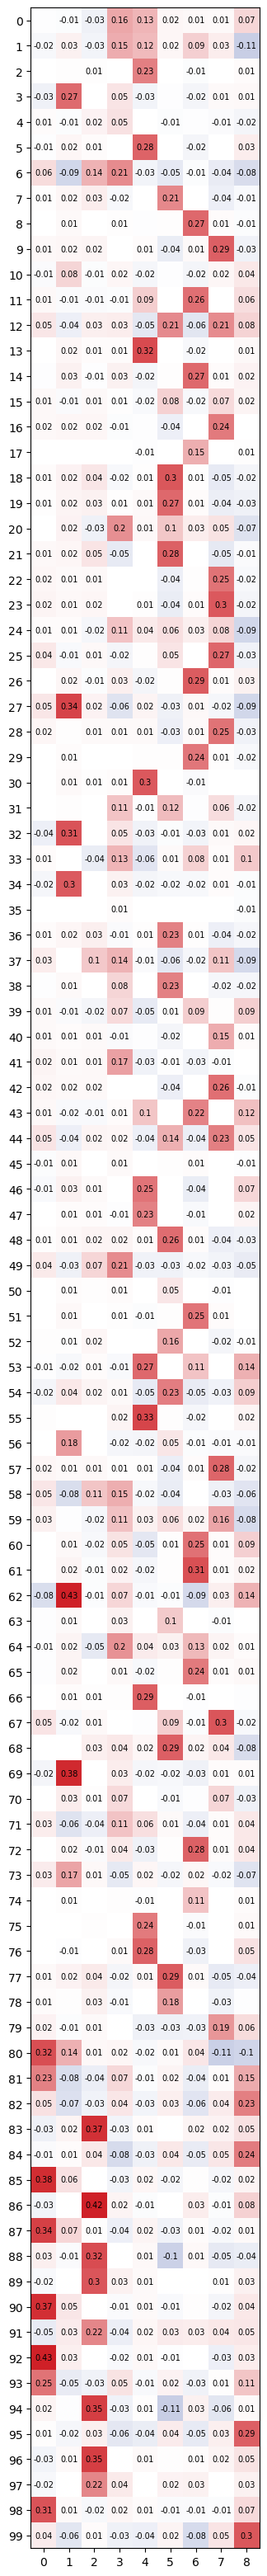

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 40))
mat = Q
img = ax.imshow(mat, cmap=cmap, vmin = -0.4, vmax = 0.4)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(mat.shape[1]))
ax.set_yticks(np.arange(mat.shape[0]))
plt.show()

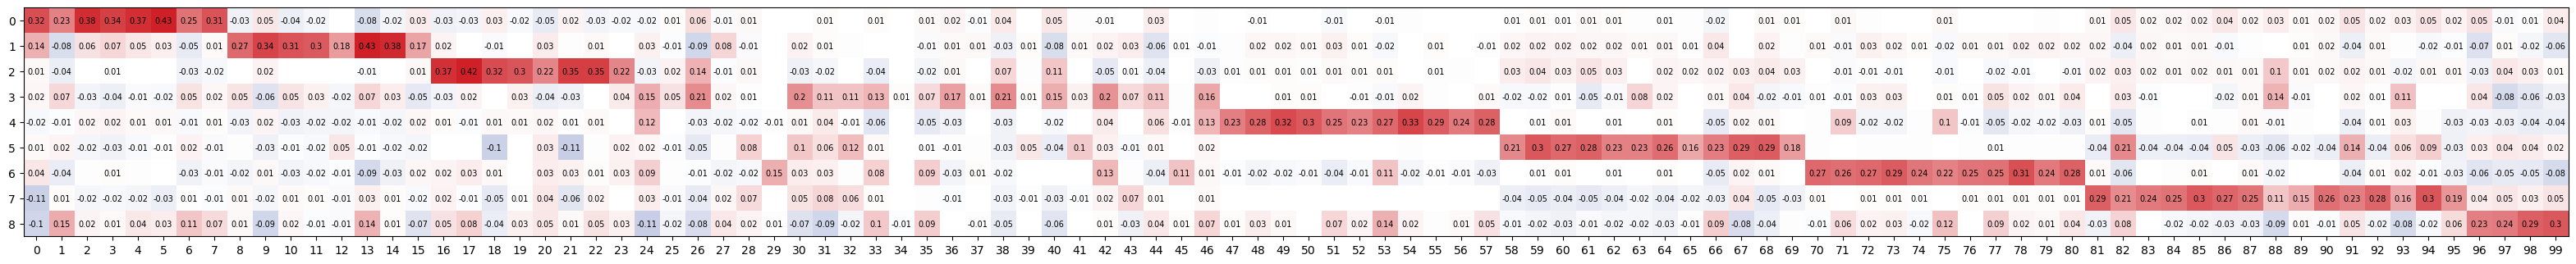

In [13]:
order = np.array([80, 81, 85, 87, 90, 92, 93, 98,  3, 27, 32, 34, 56, 62, 69, 73, 83,
       86, 88, 89, 91, 94, 96, 97,  1,  4,  6, 10, 15, 17, 20, 24, 31, 33,
       35, 39, 41, 45, 49, 50, 58, 63, 64, 70, 71, 74,  0,  2,  5, 13, 30,
       46, 47, 53, 55, 66, 75, 76,  7, 18, 19, 21, 36, 38, 48, 52, 54, 68,
       77, 78,  8, 11, 14, 26, 29, 43, 51, 60, 61, 65, 72,  9, 12, 16, 22,
       23, 25, 28, 37, 40, 42, 44, 57, 59, 67, 79, 82, 84, 95, 99])

Q_permuted = permute_input_matrix(Q, order).T
fig, ax = plt.subplots(1, 1, figsize = (40, 50))
mat = Q_permuted
img = ax.imshow(mat, cmap=cmap, vmin = -0.4, vmax = 0.4)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(mat.shape[1]))
ax.set_yticks(np.arange(mat.shape[0]))
plt.show()

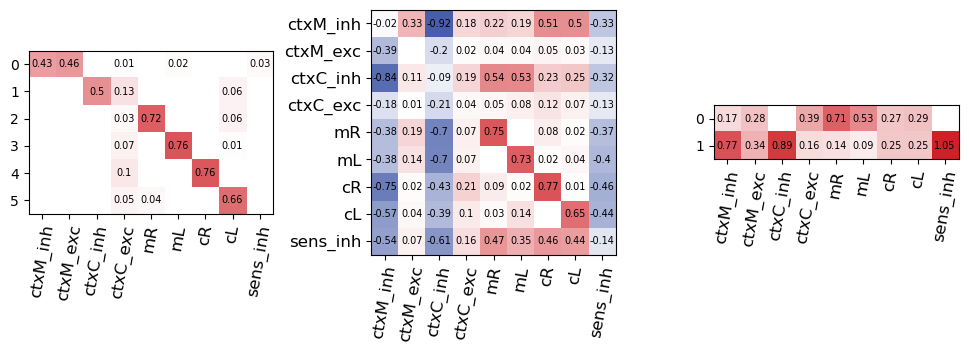

In [14]:
clusters = ["ctxM_inh", 'ctxM_exc','ctxC_inh',"ctxC_exc", "mR", "mL", "cR", "cL", "sens_inh"]#, "weird"]
fig, ax = plt.subplots(1, 3, figsize = (12, 6))

mat = 3 * w_inp_init.T
img = ax[0].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[0].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[0].set_xticks(np.arange(mat.shape[1]))
ax[0].set_yticks(np.arange(mat.shape[0]))
ax[0].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[0].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = 10 * w_rec_init
img = ax[1].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[1].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[1].set_xticks(np.arange(mat.shape[1]))
ax[1].set_yticks(np.arange(mat.shape[0]))
ax[1].set_xticklabels(clusters, rotation=80, fontsize=12)
ax[1].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = 8*w_out_init
img = ax[2].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[2].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[2].set_xticks(np.arange(mat.shape[1]))
ax[2].set_yticks(np.arange(mat.shape[0]))
ax[2].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[2].set_yticklabels(clusters, rotation=0, fontsize=12)
plt.subplots_adjust(wspace=0.4)
plt.show()


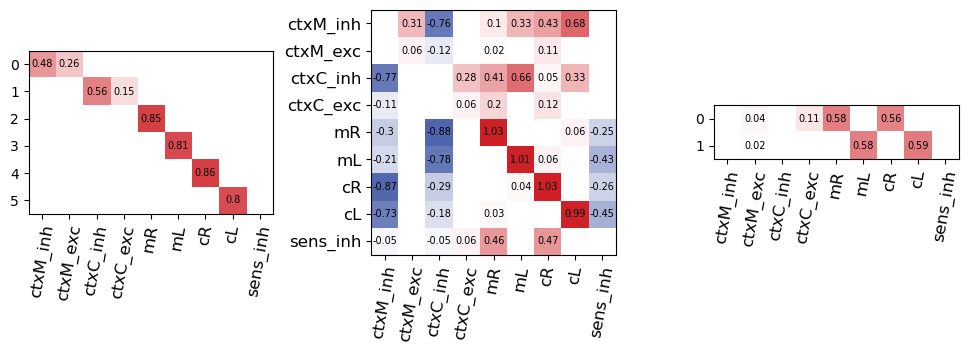

In [15]:
clusters = ["ctxM_inh", 'ctxM_exc','ctxC_inh',"ctxC_exc", "mR", "mL", "cR", "cL", "sens_inh"]#, "weird"]
fig, ax = plt.subplots(1, 3, figsize = (12, 6))

mat = W_inp_inferred.T
img = ax[0].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[0].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[0].set_xticks(np.arange(mat.shape[1]))
ax[0].set_yticks(np.arange(mat.shape[0]))
ax[0].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[0].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = W_rec_inferred
img = ax[1].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[1].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[1].set_xticks(np.arange(mat.shape[1]))
ax[1].set_yticks(np.arange(mat.shape[0]))
ax[1].set_xticklabels(clusters, rotation=80, fontsize=12)
ax[1].set_yticklabels(clusters, rotation=0, fontsize=12)

mat = W_out_inferred
img = ax[2].imshow(mat, cmap=cmap, vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.005:
        ax[2].text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax[2].set_xticks(np.arange(mat.shape[1]))
ax[2].set_yticks(np.arange(mat.shape[0]))
ax[2].set_xticklabels(clusters, rotation=80, fontsize=12)
# ax[2].set_yticklabels(clusters, rotation=0, fontsize=12)
plt.subplots_adjust(wspace=0.4)
plt.show()


In [16]:
activation_fun_circuit = lambda x: np.maximum(0, x)
N_LC = W_rec_inferred.shape[0]
circuit = RNN_numpy(N=N_LC, W_rec=W_rec_inferred, W_inp=W_inp_inferred, W_out=W_out_inferred, dt=dt, tau=tau, activation=activation_fun_circuit)
circuit.y = np.zeros(N_LC)

# defining RNN
N_RNN = rnn_data["N"]
x = np.random.randn(N_RNN)
W_rec = RNN_params["W_rec"]
W_inp = RNN_params["W_inp"]
W_out = RNN_params["W_out"]
dt = net_params["dt"]
tau = net_params["tau"]
activation_fun_RNN_np = lambda x: np.maximum(x, 0)
RNN = RNN_numpy(N=N_RNN, W_rec=W_rec, W_inp=W_inp, W_out=W_out, dt=dt, tau=tau, activation=activation_fun_RNN_np)
RNN.y = np.zeros(N_RNN)

analyzer = LCAnalyzer(circuit, labels=clusters)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
mask = np.array(rnn_config["mask"])

#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=mse_scoring,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=sigma_rec,
                                          sigma_inp=sigma_inp)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

# Total variance
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()
RNN.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
RNN_trajectories = RNN.get_history()
RNN_output =RNN.get_output()
circuit.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories = circuit.get_history()
lc_output = circuit.get_output()

lc_trajectories_emb = np.einsum("ji, ikp->jkp", Q, lc_trajectories)
RNN_trajectories_proj = np.einsum("ij, ikp->jkp", Q, RNN_trajectories)
r2_tot = np.mean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.mean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {r2_tot}")
print(f"Projected R2: {r2_proj}")
scores = {"mse_score": mse_score, "r2_tot":r2_tot, "r2_proj" : r2_proj}

MSE: 0.02134952
Total R2: 0.9739595825825667
Projected R2: 0.9533469036765343


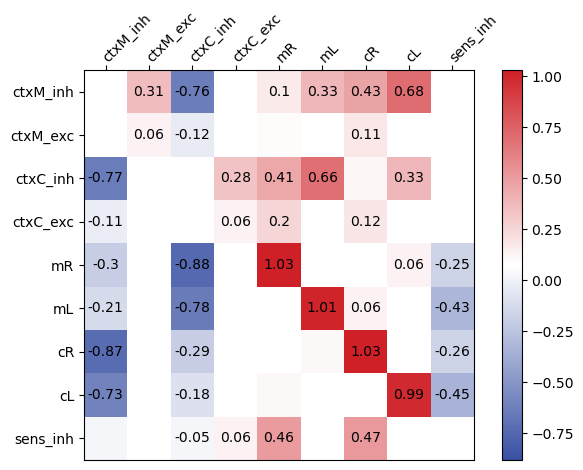

In [17]:
w_inp = net_params["W_inp"]
w_rec = net_params["W_rec"]
w_out = net_params["W_out"]
fig_w_rec = analyzer.plot_recurrent_matrix()
plt.show()

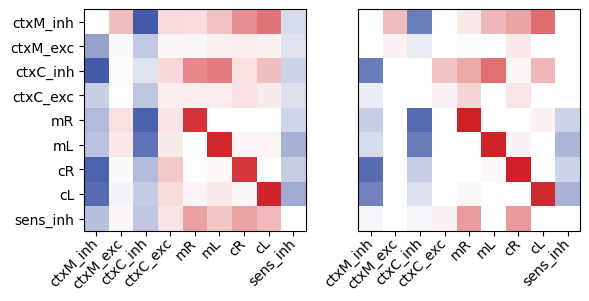

In [18]:
w_rec_bar = Q.T @ np.array(rnn_data["W_rec"]) @ Q
fig_w_rec_comparison = analyzer.plot_recurrent_matrix_comparison(w_rec_bar=w_rec_bar)
plt.show()

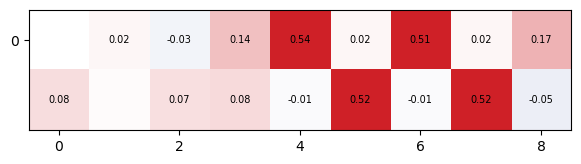

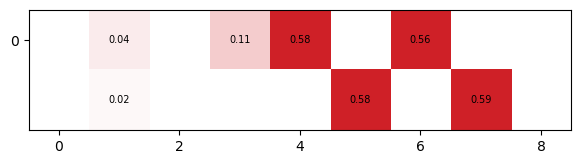

In [19]:
plot_matrix(W_out @ Q, vmin = -0.5, vmax = 0.5, show_numbers=True)
plot_matrix(w_out, vmin = -0.5, vmax = 0.5, show_numbers=True)

Plotting random trials


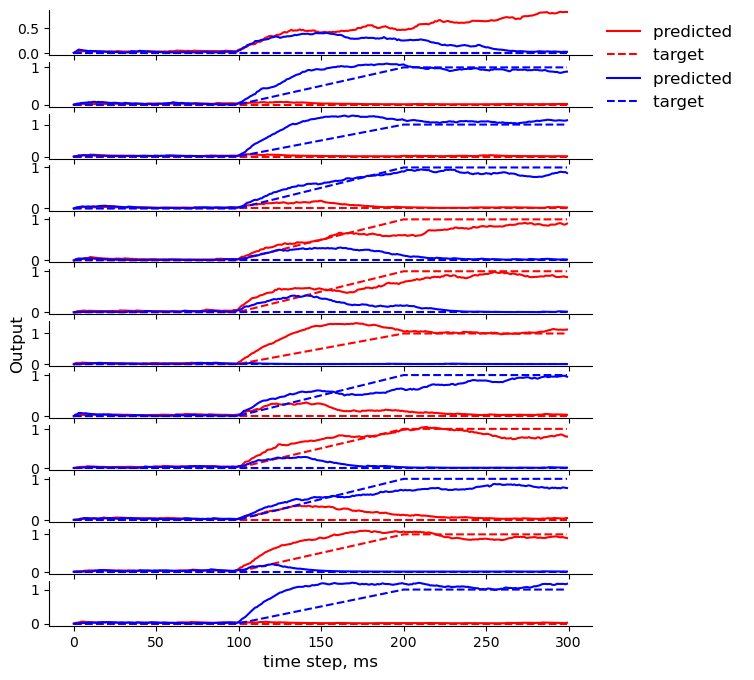

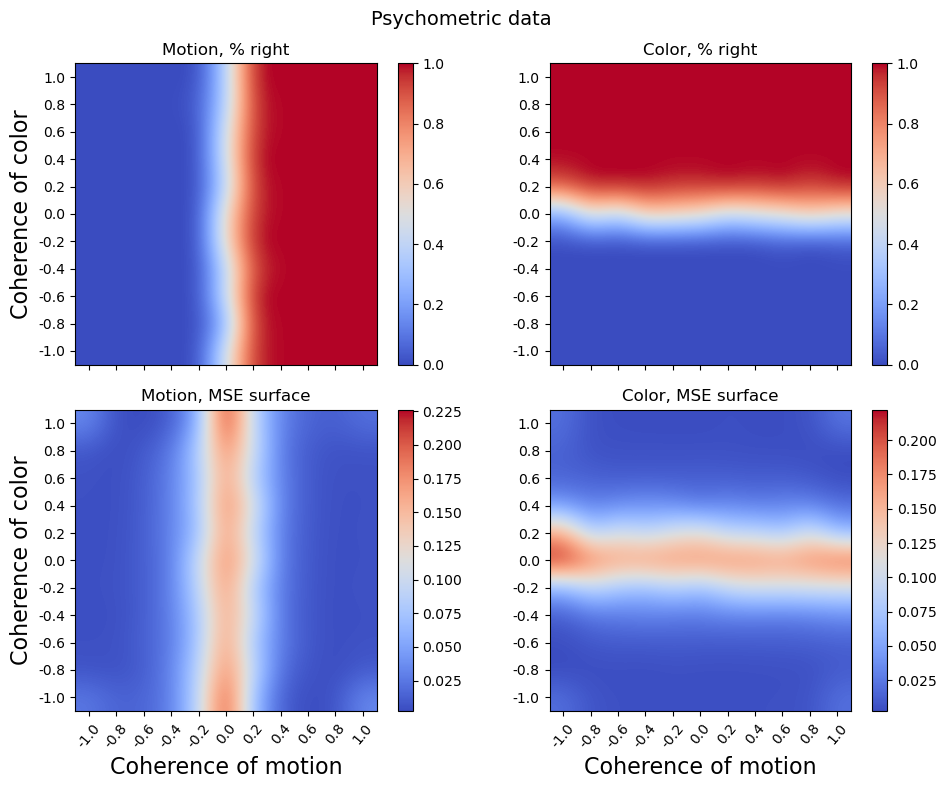

In [20]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
plt.show()

num_levels = len(task_data["coherences"])
analyzer.calc_psychometric_data(task, mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data()
plt.show()

Analyzing fixed points
Calculating Line Attractor analytics
Analyzing points on a line attractor in motion context...


  0%|          | 0/101 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/101 [00:00<?, ?it/s]

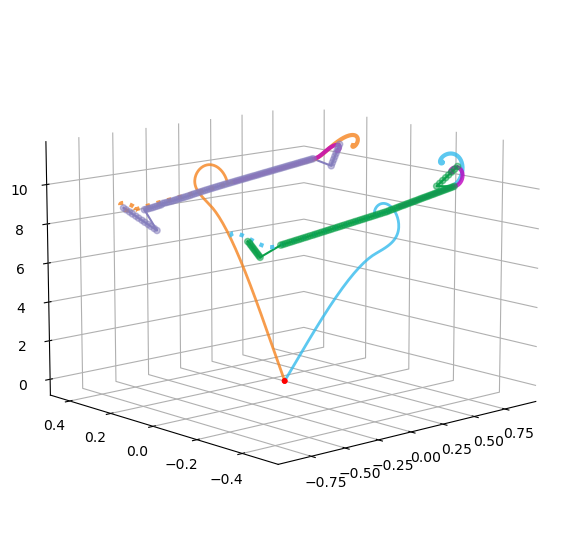

In [21]:
print(f"Analyzing fixed points")
dsa = DynamicSystemAnalyzerCDDM(circuit)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 15,
          "patience": 50,
          "stop_length": 50,
          "mode": "approx"}
dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)
print(f"Calculating Line Attractor analytics")
dsa.calc_LineAttractor_analytics(N_points=101)
fig_LA3D = dsa.plot_LineAttractor_3D()
plt.show()